In [1]:
from PIL import Image
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import notebook
import torchvision
from torchvision import transforms
from torchvision import models
from collections import Counter
from pathlib import Path
from sklearn.metrics import confusion_matrix, recall_score
import seaborn as sn
# !pip install torchsummary 
# import torchsummary

In [2]:
print(*torch.__config__.show().split("\n"), sep="\n")

PyTorch built with:
  - GCC 7.3
  - Intel(R) Math Kernel Library Version 2019.0.3 Product Build 20190125 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v0.20.5 (Git Hash 0125f28c61c1f822fd48570b4c1066f96fcb9b2e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CUDA Runtime 10.0
  - NVCC architecture flags: -gencode;arch=compute_35,code=sm_35;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_50,code=compute_50
  - CuDNN 7.6.3
  - Magma 2.5.1
  - Build settings: BLAS=MKL, BUILD_NAMEDTENSOR=OFF, BUILD_TYPE=Release, CXX_FLAGS= -Wno-deprecated -fvisibility-inlines-hidden -fopenmp -DUSE_FBGEMM -DUSE_QNNPACK -DUSE_PYTORCH_QNNPACK -O2 -fPIC -Wno-narrowing -Wall -Wextra -Wno-missing-field-initializers -Wno-type-limits -Wno-array-bounds -Wno-unknown-pragmas -Wno-sign-compare -Wno-unused-parameter -Wno-unused-variabl

In [3]:
torch.get_num_threads()

1

In [4]:
torch.set_num_threads(4)

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
df_train = pd.read_csv('/kaggle/input/bengaliai-cv19/train.csv')
df_test = pd.read_csv('/kaggle/input/bengaliai-cv19/test.csv')
df_class = pd.read_csv('/kaggle/input/bengaliai-cv19/class_map.csv')
df_submission = pd.read_csv('/kaggle/input/bengaliai-cv19/sample_submission.csv')

In [7]:
def make_tensordataset_from_dfs(parquet_locs, label_loc=None):
    ids = []
    X = []
#     parquet_locs = notebook.tqdm(parquet_locs)
    for parquet_loc in parquet_locs:
        df = pd.read_parquet(parquet_loc)
        ids.extend(df.image_id.tolist())
        x = df.iloc[:, 1:].to_numpy(dtype=np.uint8)
        del df
        X.append(x)
    X = np.vstack(X)
    X = X.reshape(-1, 1, 137, 236)
    X = torch.from_numpy(X)
    ids = dict((s,i) for (i,s) in enumerate(ids))
    if label_loc is None:
        return TensorDataset(X)
    else:
        graphemes = torch.zeros(X.shape[0], dtype=torch.long)
        vowel_diacs = torch.zeros(X.shape[0], dtype=torch.long)
        consonant_diacs = torch.zeros(X.shape[0], dtype=torch.long)
        lbl_df = pd.read_csv(label_loc)
        for row in lbl_df.itertuples():
            if row.image_id not in ids:
                continue
            idx = ids[row.image_id]
            graphemes[idx] = row.grapheme_root
            vowel_diacs[idx] = row.vowel_diacritic
            consonant_diacs[idx] = row.consonant_diacritic
        return TensorDataset(X, graphemes, vowel_diacs, consonant_diacs)

In [8]:
ds = make_tensordataset_from_dfs(['/kaggle/input/bengaliai-cv19/train_image_data_{}.parquet'.format(i) for i in range(4)], '/kaggle/input/bengaliai-cv19/train.csv')

(tensor(72),
 tensor(4),
 tensor(0),
 tensor(255, dtype=torch.uint8),
 tensor(34, dtype=torch.uint8))

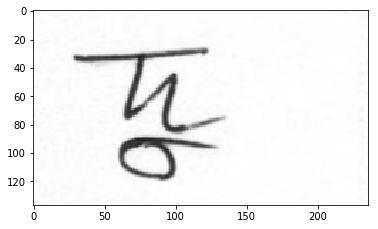

In [9]:
plt.imshow(ds[100000][0].permute(1, 2, 0).reshape(137, 236), cmap='gray', vmin=0, vmax=255)
ds[100000][1], ds[100000][2], ds[100000][3], ds[100000][0].max(), ds[100000][0].min()

In [10]:
tr_indices, va_indices = train_test_split(list(range(len(ds))), test_size=.1, train_size=.9, random_state=42)#, stratify=ds.tensors[1])

In [11]:
tr_ds = Subset(ds, tr_indices)
va_ds = Subset(ds, va_indices)

In [12]:
len(ds), len(tr_ds), len(va_ds)

(200840, 180756, 20084)

In [13]:
n_graphemes, n_vowel_diacs, n_consonant_diacs = len(set(df_train['grapheme_root'])), len(set(df_train['vowel_diacritic'])), len(set(df_train['consonant_diacritic']))

In [14]:
def make_linear_block(in_size, out_size):
    block = nn.Sequential(
        nn.Linear(in_size, out_size), 
        nn.ReLU(), 
        nn.BatchNorm1d(num_features=out_size),
    )
    nn.init.xavier_normal_(block[0].weight.data)
    nn.init.zeros_(block[0].bias.data)
    return block

def make_ff_predictor(in_size, intermediate_size, out_size, layer_count):
    layers = [make_linear_block(in_size, intermediate_size)]
    for i in range(layer_count):
        layers.append(make_linear_block(intermediate_size, intermediate_size))
    layers.append(make_linear_block(intermediate_size, out_size))
    layers = nn.Sequential(*layers)
    return layers

def make_squeeze_predictor(in_size, out_size):
    return nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Conv2d(in_size, out_size, kernel_size=(1, 1)),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(1,1)),
            nn.Flatten()
        )

class BanglaHandwrittenGraphemeNN(nn.Module):
    def __init__(self):
        super(BanglaHandwrittenGraphemeNN, self).__init__()
        base = models.resnet50(pretrained=False)
        base.load_state_dict(torch.load('/kaggle/input/pretrained-pytorch-models/resnet50-19c8e357.pth'))
        base.fc = nn.Identity()
        self.base = base
        feature_size = 2048
        self.grapheme_predictor = make_ff_predictor(feature_size, 512, n_graphemes, 2)
        self.vowel_diac_predictor = make_ff_predictor(feature_size, 512, n_vowel_diacs, 1)
        self.consonant_diacs = make_ff_predictor(feature_size, 512, n_consonant_diacs, 1)

    def convert_to_grayscale(self):
        with torch.no_grad():
            conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            conv1.weight.data = torch.sum(model.base.conv1.weight.data, dim=1, keepdim=True)
            self.base.conv1 = conv1
            
    def freeze(self):
        for p in self.base.parameters():
            p.requires_grad = False
        
    def unfreeze(self):
        for p in self.base.parameters():
            p.requires_grad = True
        
    def forward(self, x):
        features = self.base(x)
        g_pred = self.grapheme_predictor(features)
        v_pred = self.vowel_diac_predictor(features)
        c_pred = self.consonant_diacs(features)
        return g_pred, v_pred, c_pred

In [15]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [16]:
model = BanglaHandwrittenGraphemeNN().to(device)

In [17]:
model.convert_to_grayscale()

In [18]:
model.unfreeze()

In [19]:
tr_dl = DataLoader(tr_ds, batch_size=64, num_workers=0, pin_memory=True, shuffle=True)
va_dl = DataLoader(va_ds, batch_size=64, num_workers=0, pin_memory=True)

In [20]:
criterion = LabelSmoothingLoss(11)

In [21]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [22]:
tr_losses = []
va_losses = []

In [23]:
mean = lambda l: sum(l) / len(l)


2.9985944659836523 1.5648894599792176 0.6317833791791865 0.8019216268252483



1.3728819756655937 (0.4965830009644199, 0.32815896748167694, 0.5481400072194968)
0.8740561169312225
0.9648834803127257
0.9594347127824838
[[4092   62    4    3   42   15   15   12    2    1    0]
 [  39 3595    0   14    0    0    1    1    0   12    0]
 [   3    0 2566    1    0    0    0    4    3    0    0]
 [   1   21    0 1554    0    0    0    0    0    1    2]
 [  43    1    0    0 1819    5   11    2    0    0    0]
 [  14    4    0    0   11  484    9    0    0    0    0]
 [  10    1    0    0    2    7  428    0    0    0    0]
 [  12    1    3    0    0    0    0 2789    8   45    1]
 [   0    0    2    0    0    0    0   12  314    3    2]
 [   0    9    0    0    0    0    0   17    0 1585    7]
 [   0    1    0    1    0    0    0    2    0   17  336]]
[[12068     3   114     0   270    92     8]
 [   20   661    10     0     1     1     0]
 [   67     0  2210    13     7    11     0]
 [    0     0     0    61     1     0     0]
 [   16     0     3     0  2110     0    1

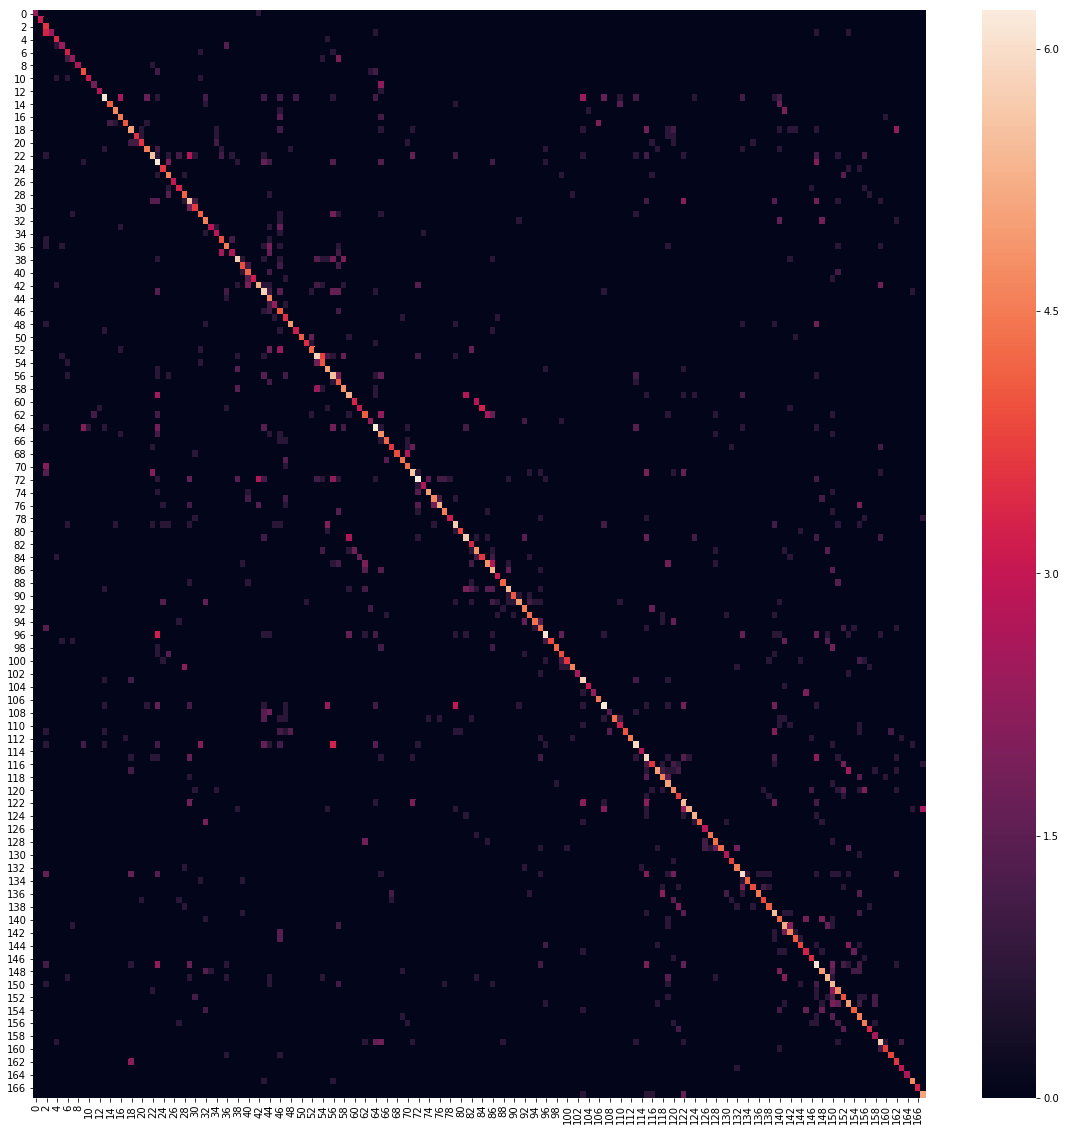

KeyboardInterrupt: 

In [24]:
num_epochs = 20
epochs = range(num_epochs)
# epochs = notebook.tqdm(range(num_epochs))
for epoch in epochs:
    model.train()
    count = 0
    batches = tr_dl
    batches = notebook.tqdm(tr_dl)
    for batch in batches:
        count += 1
        optimizer.zero_grad()
        img, g, v, c = batch
        img, g, v, c = img.to(device), g.to(device), v.to(device), c.to(device)
        img = img / 255.0
        g_pred, v_pred, c_pred = model(img)
        g_loss = criterion(g_pred, g)
        v_loss = criterion(v_pred, v)
        c_loss = criterion(c_pred, c)
        loss = 2.0 * g_loss + v_loss + c_loss
        loss.backward()
        optimizer.step()
        tr_losses.append((g_loss.item(), v_loss.item(), c_loss.item()))
    print(mean([sum(t) for t in tr_losses]), mean([t[0] for t in tr_losses]), mean([t[1] for t in tr_losses]), mean([t[2] for t in tr_losses]))
    with torch.no_grad():
        model.eval()
        avg_g_loss = 0.0
        avg_v_loss = 0.0
        avg_c_loss = 0.0
        g_true = []
        v_true = []
        c_true = []
        g_preds = []
        v_preds = []
        c_preds = []
        count = 0
        batches = va_dl
        batches = notebook.tqdm(va_dl)
        for batch in batches:
            count += 1
            img, g, v, c = batch
            img, g, v, c = img.to(device), g.to(device), v.to(device), c.to(device)
            img = img / 255.0
            g_pred, v_pred, c_pred = model(img)
            g_loss = criterion(g_pred, g)
            v_loss = criterion(v_pred, v)
            c_loss = criterion(c_pred, c)
            avg_g_loss += g_loss.item()
            avg_v_loss += v_loss.item()
            avg_c_loss += c_loss.item()
            g_true.extend(g.tolist())
            v_true.extend(v.tolist())
            c_true.extend(c.tolist())
            g_preds.extend(g_pred.argmax(1).tolist())
            v_preds.extend(v_pred.argmax(1).tolist())
            c_preds.extend(c_pred.argmax(1).tolist())
        avg_g_loss /= count
        avg_v_loss /= count
        avg_c_loss /= count
        va_losses.append((avg_g_loss, avg_v_loss, avg_c_loss))
        print(sum(va_losses[-1]), va_losses[-1])
        print(recall_score(g_true, g_preds, average='macro'))
        print(recall_score(v_true, v_preds, average='macro'))
        print(recall_score(c_true, c_preds, average='macro'))
        print(confusion_matrix(v_true, v_preds))
        print(confusion_matrix(c_true, c_preds))
        plt.figure(figsize = (20, 20))
        sn.heatmap(np.log1p(confusion_matrix(g_true, g_preds)))
        plt.show()

In [ ]:
plt.plot([sum(t) for t in tr_losses])

In [ ]:
plt.plot([t[0] for t in tr_losses])

In [ ]:
plt.plot([t[1] for t in tr_losses])

In [ ]:
plt.plot([t[2] for t in tr_losses])

In [ ]:
plt.plot([t[0] for t in va_losses])

In [ ]:
plt.plot([t[1] for t in va_losses])

In [ ]:
plt.plot([t[2] for t in va_losses])

In [ ]:
torch.save(model.state_dict(), '/kaggle/working/model.pth')